
Made by: Andrei Kulchyk (155489) and Fiodar Piatrovich (155174)

[Github](https://github.com/aaakulchyk/put-evolutionary-computations)

# Description of a problem

We are given three columns of integers with a row for each node. The first two columns contain x and y coordinates of the node positions in a plane. The third column contains node costs. The goal is to select exactly 50% of the nodes (if the number of nodes is odd we round the number of nodes to be selected up) and form a Hamiltonian cycle (closed path) through this set of nodes such that the sum of the total length of the path plus the total cost of the selected nodes is minimized.

The distances between nodes are calculated as Euclidean distances rounded mathematically to
integer values. The distance matrix should be calculated just after reading an instance and then only
the distance matrix (no nodes coordinates) should be accessed by optimization methods to allow
instances defined only by distance matrices.

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import random
from pathlib import Path

from joblib import Parallel, delayed
from time import perf_counter

import numpy as np
import pandas as pd

from hamiltonian_cycle.experiment import perform_experiment
from hamiltonian_cycle.algorithms.lab6 import (
    MultipleStartLocalSearch,
    IteratedLocalSearch,
)
from hamiltonian_cycle.algorithms.lab1 import init_random_solution
from hamiltonian_cycle.plots import plot_solution
from hamiltonian_cycle.costs import dm, function_cost

from time import perf_counter

In [3]:
def read_dataset_csv(csv_path: Path) -> pd.DataFrame:
    return pd.read_csv(csv_path, sep=";", names=["x", "y", "cost"])


DATA_DIR = Path("../data").resolve()

ds_a = read_dataset_csv(DATA_DIR / "TSPA.csv")
ds_b = read_dataset_csv(DATA_DIR / "TSPB.csv")

dm_a = dm(ds_a)
dm_b = dm(ds_b)

# MSLS

In [ ]:
class MSLSMetrics:
    def __init__(self, solution: pd.DataFrame, execution_time: float):
        self.cost = function_cost(solution)
        self.solution = list(solution.index)
        self.execution_time = execution_time


def run_msls(msls: MultipleStartLocalSearch) -> MSLSMetrics:
    start_time = perf_counter()
    mlsm_solution = msls()
    end_time = perf_counter()
    execution_time = end_time - start_time
    return MSLSMetrics(mlsm_solution, execution_time)

#### Results on Dataset A

Best solution: [158, 53, 100, 26, 97, 152, 1, 101, 86, 75, 2, 129, 82, 120, 44, 25, 16, 171, 175, 113, 56, 31, 78, 145, 92, 57, 55, 52, 185, 119, 40, 81, 90, 27, 165, 106, 178, 3, 49, 14, 144, 102, 62, 9, 148, 124, 94, 63, 79, 80, 176, 137, 23, 186, 89, 183, 143, 0, 117, 93, 140, 68, 46, 115, 139, 41, 193, 159, 69, 108, 18, 22, 146, 34, 48, 54, 177, 4, 112, 84, 35, 184, 160, 42, 43, 116, 65, 131, 149, 59, 51, 151, 133, 162, 123, 127, 70, 135, 154, 180]
Objective function statistics:
minimum.cost = 70662
mean = 71267.4
maximum.cost= 71693


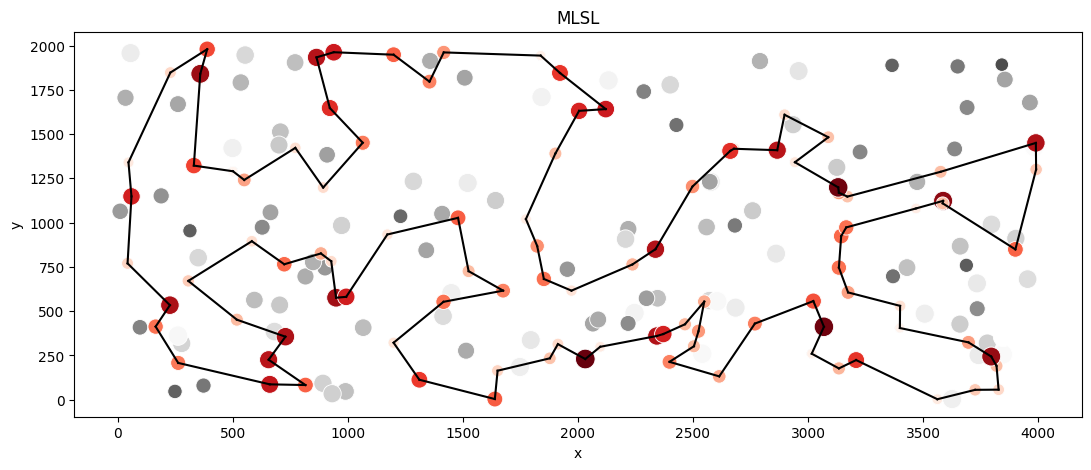

In [5]:
msls_runs = 20
msls_iterations = 200

msls = MultipleStartLocalSearch(ds=ds_a, dm=dm_a, iterations=msls_iterations)


metrics: list[MSLSMetrics] = Parallel(n_jobs=-1)(
    delayed(run_msls)(msls) for _ in range(msls_runs)
)

minimum = min(metrics, key=lambda x: x.cost)
mean = sum([metric.cost for metric in metrics]) / len(metrics)
maximum = max(metrics, key=lambda x: x.cost)

print(f"Best solution: {minimum.solution}")
print("Objective function statistics:")
print(f"{minimum.cost = }\n{mean = }\n{maximum.cost= }")
plot_solution(ds_a, minimum.solution, title="MLSL")

#### Results on Dataset B

In [ ]:
msls_runs = 20
msls_iterations = 200

msls = MultipleStartLocalSearch(ds=ds_b, dm=dm_b, iterations=msls_iterations)


metrics: list[MSLSMetrics] = Parallel(n_jobs=-1)(
    delayed(run_msls)(msls) for _ in range(msls_runs)
)

minimum = min(metrics, key=lambda x: x.cost)
mean = sum([metric.cost for metric in metrics]) / len(metrics)
maximum = max(metrics, key=lambda x: x.cost)

Best solution: [11, 182, 138, 33, 160, 29, 0, 109, 35, 143, 159, 106, 124, 62, 18, 55, 34, 170, 152, 183, 140, 28, 20, 148, 47, 94, 66, 172, 179, 185, 95, 86, 166, 194, 176, 180, 113, 103, 114, 137, 127, 89, 163, 165, 187, 153, 81, 77, 111, 104, 8, 82, 21, 141, 61, 36, 177, 5, 45, 142, 78, 175, 80, 190, 136, 73, 164, 54, 31, 193, 117, 198, 1, 135, 102, 63, 100, 40, 107, 10, 133, 122, 131, 112, 121, 51, 90, 147, 6, 188, 169, 132, 70, 3, 15, 145, 13, 195, 168, 139]
Objective function statistics:
minimum.cost = 45321
mean = 45751.25
maximum.cost= 46137


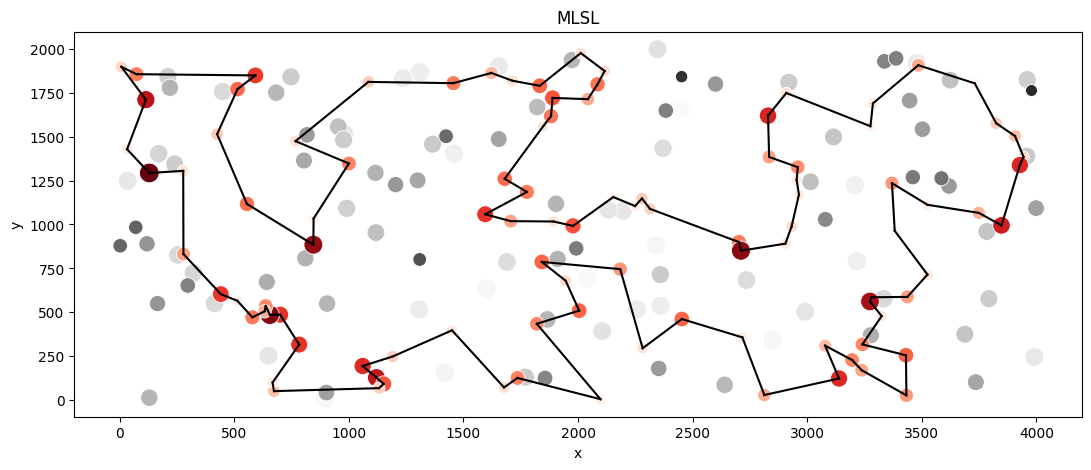

In [8]:
print(f"Best solution: {minimum.solution}")
print("Objective function statistics:")
print(f"{minimum.cost = }\n{mean = }\n{maximum.cost= }")
plot_solution(ds_b, minimum.solution, title="MLSL")

## ILS

In [ ]:
from lab6 import IteratedLocalSearch

msls_runs = 20
msls_iterations = 200

msls = Iter(ds=ds_b, dm=dm_b, iterations=msls_iterations)


metrics: list[MSLSMetrics] = Parallel(n_jobs=-1)(
    delayed(run_msls)(msls) for _ in range(msls_runs)
)

minimum = min(metrics, key=lambda x: x.cost)
mean = sum([metric.cost for metric in metrics]) / len(metrics)
maximum = max(metrics, key=lambda x: x.cost)

# Summary

In [ ]:
a_res = pd.DataFrame(
    {
        "random_cycle_edge_steepest": [72046, 74033.715, 78801, 9.54],
        "random_cycle_edge_candidate_heur": [72046, 74033.715, 78801, 1.23],
    },
    index=pd.MultiIndex.from_tuples(
        [
            ("Dataset A", "min"),
            ("Dataset A", "mean"),
            ("Dataset A", "max"),
            ("Dataset A", "seconds/iter"),
        ]
    ),
).T

b_res = pd.DataFrame(
    {
        "random_cycle_edge_steepest": [45393, 48264.78, 50697, 3000],
        "random_cycle_edge_candidate_heur": [72046, 74033.715, 78801, 1.27],
    },
    index=pd.MultiIndex.from_tuples(
        [
            ("Dataset B", "min"),
            ("Dataset B", "mean"),
            ("Dataset B", "max"),
            ("Dataset B", "seconds/iter"),
        ]
    ),
).T

a_res.join(b_res).sort_values(by=("Dataset A", "mean"))

Dataset A                                   \
                                       min       mean      max seconds/iter   
random_cycle_edge_steepest         72046.0  74033.715  78801.0         9.54   
random_cycle_edge_candidate_heur   72046.0  74033.715  78801.0         1.23   

                                 Dataset B                                   
                                       min       mean      max seconds/iter  
random_cycle_edge_steepest         45393.0  48264.780  50697.0         9.02  
random_cycle_edge_candidate_heur   72046.0  74033.715  78801.0         1.27

# Conclusion

`Candidate moves` heuristic improves significantly the computation time, but at cost of quality, which is rather significant